In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import feather

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
def fetch_data(cell_number, type):
    if type == 'charge': prefix = '_c'
    elif type == 'discharge': prefix = '_dc'
    else: prefix = '_imp'

    num = '0' + str(cell_number) if cell_number != 18 else str(cell_number)
    df = feather.read_dataframe('data/B00' + num + prefix + '.feather')
    return df

def get_timeseries(cell_number):
    df = fetch_data(cell_number, 'discharge')
    cap = []
    for i in range(len(df)):
        cap.append(df['data'][i]['Capacity'])

    return cap

def convert_to_usable(ls, scale = True):
    global scaler
    X, Y = [], []

    if scale:
        scaler = MinMaxScaler(feature_range = (0, 1))
        ls = scaler.fit_transform(np.array(ls).reshape(-1,1))

    for i in range(len(ls)-1):
        X.append(ls[i])
        Y.append(ls[i+1])
    #display(pd.DataFrame((X,Y), index = ['X', 'Y']).transpose())
    
    return np.array(X), np.array(Y)

def train_test(ls, test_size = 0.3):
    X, Y = convert_to_usable(ls, True)

    test_len = int(test_size * len(X))
    train_len = len(X) - test_len

    def reshape(arr):
        return arr.reshape(arr.shape[0], 1, 1)

    test = {'X': reshape(X[-test_len:]), 'Y': reshape(Y[-test_len:])}
    train = {'X': reshape(X[:train_len]), 'Y': reshape(Y[:train_len])}

    return train, test

In [223]:
ls = get_timeseries(5)
train, test = train_test(ls)

train_x, train_y = train['X'], train['Y']
test_x, test_y = test['X'], test['Y']

In [224]:
bool(1)

True

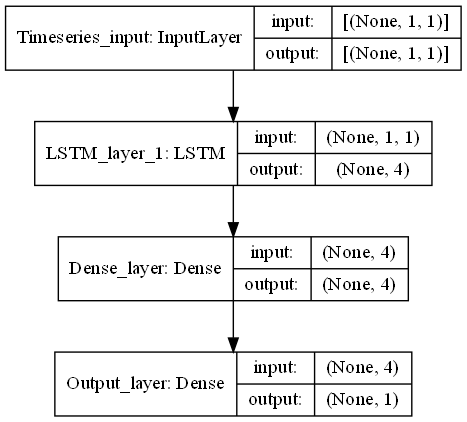

In [225]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM
from keras.utils.vis_utils import plot_model
from tqdm.keras import TqdmCallback

def create_model(lstm_sizes = [4], num_lstm = 1, plot = True):
    bool = False if num_lstm == 1 else True

    input = Input(shape = (1, 1), name = 'Timeseries_input')   
    lstm1 = LSTM(lstm_sizes[0], input_shape = (1, 1), return_sequences = bool, name = "LSTM_layer_1")(input)
    if bool: 
        try: size = lstm_sizes[1]
        except: size = lstm_sizes[0]
        lstm2 = LSTM(size, name = "LSTM_layer_2")(lstm1)

    layer = lstm1 if not bool else lstm2
    dense = Dense(4, activation = None, name = "Dense_layer")(layer)
    if bool: output = Dense(1, name = "Output_layer")(dense)
    else: output = Dense(1, name = "Output_layer")(dense)

    model = Model(inputs = input, outputs = output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    if plot: display(plot_model(model, show_shapes=True, dpi=100))

    return model

model = create_model([4], num_lstm = 1, plot = True)

In [226]:
history = model.fit(train_x, train_y, 
                    epochs = 50, 
                    batch_size = 1, 
                    verbose = 0, 
                    callbacks = [TqdmCallback(verbose = 1, ncols = 100)])

100%|█████████████████████████████████████████████| 50/50 [00:08<00:00,  5.80epoch/s, loss=0.000772]


Train Score: 0.01 RMSE
Test Score: 0.02 RMSE


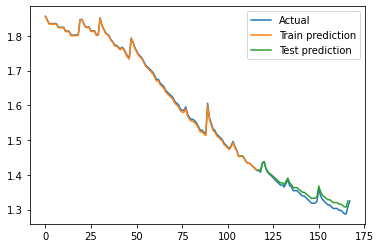

In [227]:
def invert(arr):
    return scaler.inverse_transform(arr)

original = ls
train_pred = invert(model.predict(train_x))
test_pred = invert(model.predict(test_x))
train_true = invert(train_y.reshape(-1,1))
test_true = invert(test_y.reshape(-1,1))

train_RMSE = np.sqrt(mean_squared_error(train_true, train_pred[:,0]))
print(f'Train Score: {train_RMSE:.2f} RMSE')
test_RMSE = np.sqrt(mean_squared_error(test_true, test_pred[:,0]))
print(f'Test Score: {test_RMSE:.2f} RMSE')

train_padding = np.array([np.nan for i in range(len(test_pred))]).reshape(-1,1)
test_padding = np.array([np.nan for i in range(len(train_pred))]).reshape(-1,1)
train_pred = np.vstack((train_pred, train_padding))
test_pred = np.vstack((test_padding, test_pred))

plt.plot(original, label = 'Actual')
plt.plot(train_pred, label = 'Train prediction')
plt.plot(test_pred, label = 'Test prediction')
plt.legend()
plt.show()

In [214]:
#model.save('graph_ext.pkl')

INFO:tensorflow:Assets written to: graph_ext.pkl\assets


INFO:tensorflow:Assets written to: graph_ext.pkl\assets


,temp,data,time
0,24,"{'Capacity': 1.8564874208181574, 'Current_load...",4330.391
1,24,"{'Capacity': 1.846327249719927, 'Current_load'...",4312.406
2,24,"{'Capacity': 1.8353491942234077, 'Current_load...",4291.984
3,24,"{'Capacity': 1.8352625275821128, 'Current_load...",4271.750
4,24,"{'Capacity': 1.8346455082120419, 'Current_load...",4269.375


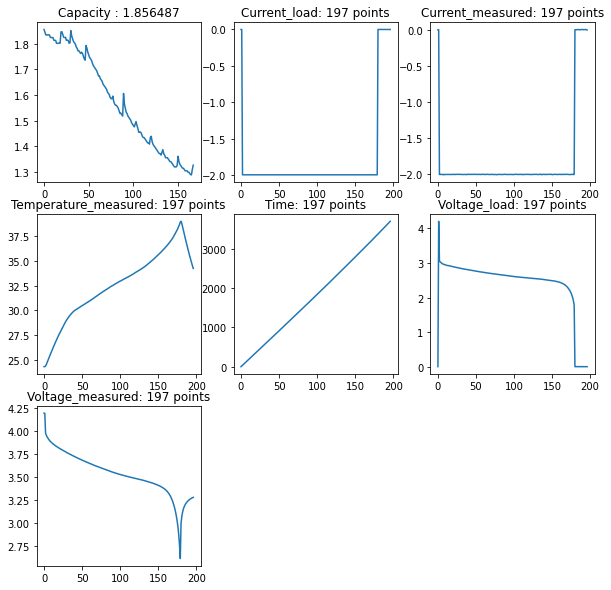

In [254]:
df_sub = fetch_data(5,'discharge')
display(df_sub.head())

for datapoint in range(1):
    plt.figure(figsize=(10,10))
    m = 0
    for i in df_sub['data'][datapoint].keys(): 
        plt.subplot(331+m)
        if i == 'Capacity':
            cap = []
            for j in range(len(df_sub)): 
                cap.append(df_sub['data'][j]['Capacity'])
            plt.plot(cap)
            plt.title(f"{i} : {cap[datapoint]:.6f}")
        else:
            plt.plot(df_sub['data'][datapoint][i])
            plt.title(i + f": {len(df_sub['data'][datapoint][i])} points")
        m += 1 
    plt.show()

In [31]:
x = []
y = cap
for datapoint in range(len(df_sub)): x.append(np.dot(df_sub['data'][datapoint]['Voltage_measured'], df_sub['data'][datapoint]['Current_measured']))

In [155]:
types = ['Current_measured', 'Temperature_measured', 'Voltage_measured']

def extract_type(df, type, scale = True):
    ls = []
    for i in range(len(df)): 
        ls.append(len(df['data'][i][type]))
        df['data'][i][type] = scaler.fit_transform(df['data'][i][type].reshape(-1,1))
    limit = np.min(ls)
    
    arr = np.zeros((1,limit,1))
    for i in range(len(df)): 
        arr = np.concatenate((arr, df['data'][i][type][:limit].reshape(1,limit,1)), axis = 0)

    arr = arr[1:]
    return arr #.reshape(arr.shape[0], arr.shape[1], 1)

df_sub = fetch_data(5,'discharge')
x_0 = extract_type(df_sub, types[0])
x_1 = extract_type(df_sub, types[1])
x_2 = extract_type(df_sub, types[2])

In [199]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, concatenate
from keras.utils.vis_utils import plot_model
from tqdm.keras import TqdmCallback

def create_model_findcap(plot = False):
    input_shape = x_0.shape[1:]
    inputs = [Input(shape = input_shape, name = 'Current_measured'), 
            Input(shape = input_shape, name = 'Temperature_measured'),
            Input(shape = input_shape, name = 'Voltage_measured')]

    layers = []
    for input in inputs:
        l1 = LSTM(64, input_shape = input_shape)(input)
        layers.append(l1)

    concat = concatenate(layers, axis = 1)
    dense = Dense(16)(concat)
    output = Dense(1)(dense)

    model = Model(inputs = inputs, outputs = output)
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    if plot: display(plot_model(model, show_shapes = True))

    return model

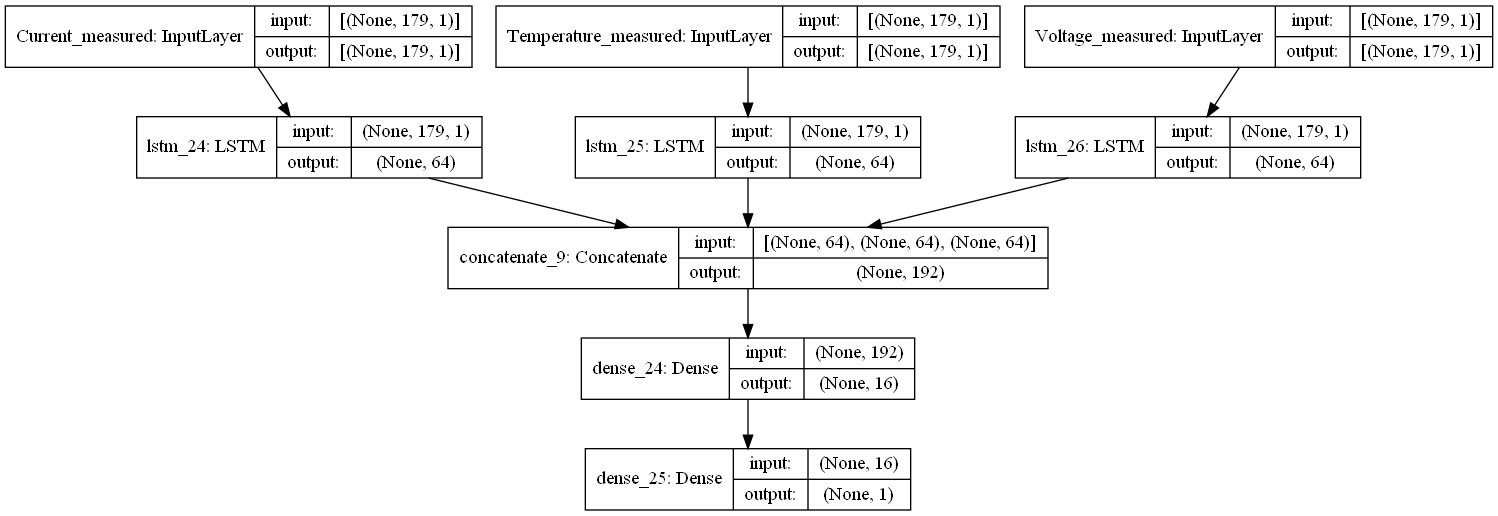

In [250]:
y = scaler.fit_transform(np.array(cap).reshape(-1,1))

train_size = int(0.7 * x_0.shape[0])
train_x0 = x_0[:train_size]
train_x1 = x_1[:train_size]
train_x2 = x_2[:train_size]
train_y = y[:train_size]

model = create_model_findcap(True)

In [251]:
model.fit([train_x0, train_x1, train_x2], train_y, 
           epochs = 100,
           batch_size = 1, 
           verbose = 0, 
           callbacks = [TqdmCallback(verbose = 0, ncols = 100)])

100%|████████████████████████████████████████████| 100/100 [07:17<00:00,  4.37s/epoch, loss=0.00502]


In [252]:
test_x0 = x_0[train_size:]
test_x1 = x_1[train_size:]
test_x2 = x_2[train_size:]
test_y = y[train_size:]

test_xn = [test_x0, test_x1, test_x2]
model.evaluate([test_x0, test_x1, test_x2], test_y)

2/2 [==============================] - 13s 38ms/step - loss: 0.0766


0.07657992839813232

In [ ]:
model.save('cap.pkl')

In [215]:
from keras.models import load_model

model1 = load_model('graph_ext.pkl')
model2 = load_model('cap.pkl')

In [231]:
caps_train = model2.predict([train_x0, train_x1, train_x2])
caps_test = model2.predict([test_x0, test_x1, test_x2])

In [ ]:
def invert(arr):
    return scaler.inverse_transform(arr)

original = get_timeseries(5)
train_pred = invert(model1.predict(caps_train))
test_pred = invert(model1.predict(caps_test[:50]))
train_true = invert(train_y.reshape(-1,1))
test_true = invert(test_y.reshape(-1,1))

train_RMSE = np.sqrt(mean_squared_error(train_true, train_pred[:,0]))
print(f'Train Score: {train_RMSE:.2f} RMSE')
test_RMSE = np.sqrt(mean_squared_error(test_true, test_pred[:,0]))
print(f'Test Score: {test_RMSE:.2f} RMSE')

train_padding = np.array([np.nan for i in range(len(test_pred))]).reshape(-1,1)
test_padding = np.array([np.nan for i in range(len(train_pred))]).reshape(-1,1)
train_pred = np.vstack((train_pred, train_padding))
test_pred = np.vstack((test_padding, test_pred))

plt.plot(original, label = 'Actual')
plt.plot(train_pred, label = 'Train prediction')
plt.plot(test_pred, label = 'Test prediction')
plt.legend()
plt.show()